<a href="https://colab.research.google.com/github/jordi1215/quantum-walk-visualization/blob/main/quantum_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install retworkx
!pip install pydot pillow
!pip install qiskit
!sudo apt install graphviz
!sudo pip install pylatexenc

import retworkx
from retworkx.visualization import graphviz_draw, mpl_draw
import pylatexenc
import matplotlib.pyplot as plt
from qiskit import *
import numpy as np
import networkx as nx
import numpy.linalg as la
from scipy.linalg import expm
from qiskit.extensions import HamiltonianGate
from qiskit.visualization import plot_histogram

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


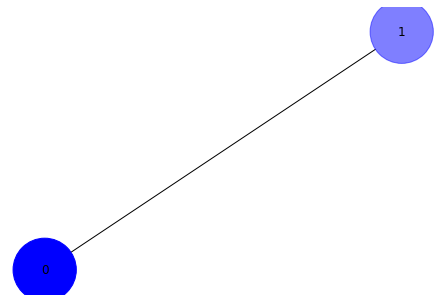

In [81]:
import retworkx

# input: adjacent matrix [[0,1],[1,0]]
# output: graph

graph = retworkx.PyDiGraph()
graph.add_nodes_from([0,1])
graph.add_edge(0,1,1)


mpl_draw(graph, node_color=[(0, 0, 1, 1.0),(0,0,1,0.5)], with_labels=True, arrows=False, node_size=4000)
plt.draw()

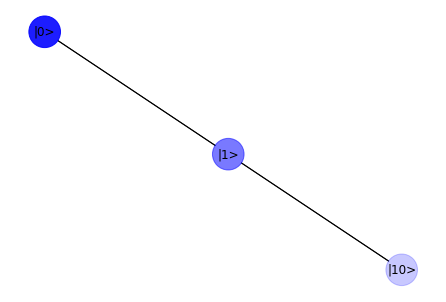

In [111]:
adj_matrix = [[0, 1, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0]]

def draw_from_adj_matrix(adj_matrix, amplitude_array):
  g = retworkx.PyDiGraph()
  n = len(adj_matrix)
  lst = ["|" + str(bin(i))[2:].zfill(int(np.log2(n))) + ">" for i in range(n)]
  g.add_nodes_from(lst)
  for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix[0])):
      if adj_matrix[i][j] != 0:
        g.add_edge(i, j, adj_matrix[i][j])
  
  colors = []
  for i in range(len(adj_matrix)):
    
    alpha = abs(amplitude_array[2**i])
    # rescale our transparency
    alpha = alpha * 0.9 + 0.1
    colors.append((0.0,0.0,1.0,alpha))
  mpl_draw(g, with_labels=True, labels=lambda node: node, arrows=False, node_size=1000, node_color= colors)
  plt.draw()

draw_from_adj_matrix(adj_P3, get_snapshots(full_mat_P3, 2*np.pi, 8)['5'][0])
#print(get_snapshots(full_mat_P2, 2*np.pi, 8)['0'][0])
# https://stackoverflow.com/questions/51565679/draw-different-graphs-at-the-same-position-co-ordinates-in-python-using-networkx

All of Ronak's and James' work on mathematical simulation is below this point.

In [12]:
def pad_zeros(adjacency):
    '''Function for padding zeros to increase adjacency 
    matrix of shape (n,n) to (2**n, 2**n).
    
    Parameters: adjacency (ndarray): adjacency of graph
    Returns: full_matrix (ndarray): new adjacency with padded zeroes
    '''
    full_matrix = np.zeros((2**len(adjacency), 2**len(adjacency)))
    for i in range(len(adjacency)):
        for j in range(len(adjacency)):
            if adjacency[i][j] != 0:
                full_matrix[2**i][2**j] = adjacency[i][j]
    return full_matrix

In the following block of code, we construct a simple path on two vertices and path on three vertices. We also show the function of the pad_zeros function, increasing the dimensionality of the adjacencies to fit our needs.

In [13]:
# construct path on 2 and three vertices and get adjacency
P2 = nx.path_graph(2)
P3 = nx.path_graph(3)
adj_P2 = nx.adjacency_matrix(P2).toarray()
adj_P3 = nx.adjacency_matrix(P3).toarray()

# pad adjacency with zeroes to increase dimensionality
full_mat_P2 = pad_zeros(adj_P2)
full_mat_P3 = pad_zeros(adj_P3)

We can use the adjacency matrix ($A$) as the Hamiltonian operator ($H$) of the quantum system, satisfying the Schrodinger equation $i \hbar \dot{\psi}=H\psi$. The adjacency matrices are Hermitian, and so $e^{-iAt}$ (the solution to this equation) is a unitary matrix. We can use this matrix exponential as the evolution operator on our quantum system of qubits. These are constructed using qiskit's HamiltonianGate object.

In [14]:
# construct HamiltonianGate from padded adjacencies
ExpGateP2 = HamiltonianGate(full_mat_P2, np.pi/2)
ExpGateP3 = HamiltonianGate(full_mat_P3, np.pi/2)

We can now use these gates in a quantum circuit to simulate a quantum walk. We put the state of the system in $|01>$ and evolve it over a time interval of $\frac{\pi}{2}$. We can measure each qubit to get the final state of the system. 

In [38]:
# construct quantum circuit for path on two vertices
qr_P2 = QuantumRegister(2, 'q')
cr_P2 = ClassicalRegister(2)
circ_P2 = QuantumCircuit(qr_P2, cr_P2)

# initialize in state |100> and add measurements
circ_P2.x(0)
circ_P2.append(ExpGateP2, qr_P2)
for i in range(len(qr_P2)):
    circ_P2.measure(qr_P2[i], cr_P2[i])

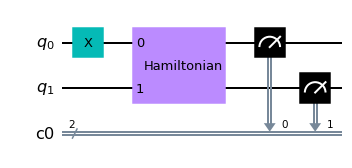

In [16]:
# visualize quantum circuit
circ_P2.draw(output='mpl')

We know from the mathematical literature on quantum walks that a path on two vertices exhibits "perfect state transfer" (PST) at time $\frac{\pi}{2}$, and so the result of this circuit should always yield $|10>$ if it starts in the state $|01>$ and vice-versa. Below, we show that the resulting counts reflect this property of the graph.

In [17]:
# simulate circuit from path on two vertices
job = execute(circ_P2, backend=BasicAer.get_backend('qasm_simulator'))
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]
print("Resulting Counts:", counts)

Resulting Counts: [{'10': 1024}]


We repeat a similar process as above for the path on three vertices.

In [18]:
# construct quantum circuit for path on three vertices
qr_P3 = QuantumRegister(3, 'q')
cr_P3 = ClassicalRegister(3)
circ_P3 = QuantumCircuit(qr_P3, cr_P3)

# initialize in state |100> and add measurements
circ_P3.x(0)
circ_P3.append(ExpGateP3, qr_P3)
for i in range(len(qr_P3)):
    circ_P3.measure(qr_P3[i], cr_P3[i])

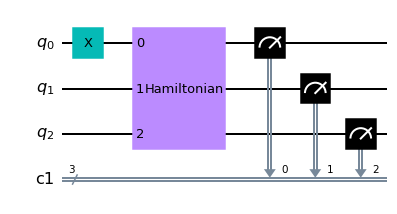

In [19]:
# visualize quantum circuit
circ_P3.draw(output='mpl')

Since the path on three vertices does not have PST at time $\frac{\pi}{2}$, we see that the resulting counts are distributed unevenly between the three different vertices. We also display these results in a histogram.

Resulting Counts: [{'100': 680, '010': 294, '001': 50}]


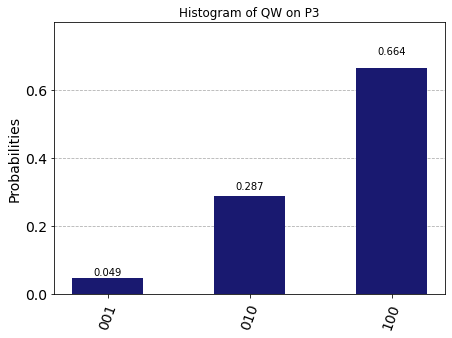

In [20]:
# simulate circuit from path on two vertices
job = execute(circ_P3, backend=BasicAer.get_backend('qasm_simulator'))
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]
print("Resulting Counts:", counts)
plot_histogram(job.result().get_counts(), color='midnightblue', title="Histogram of QW on P3")

Below we illustrate a different approach for representing qubits as a graph. While each qubit above corresponded to a node on the graph, we can instead represent more nodes on the graph by having each bitstring correspond to a different node. The quantum walk in both approaches works out the same mathematically and can thus be visualized similarly.

In [43]:
# construct random 8x8 matrix (3 qubits)
random_matrix = np.zeros((8,8))
for i in range(0,len(random_matrix)-1):
    for j in range(i+1,len(random_matrix)-1):
        random_matrix[i][j] = np.random.randint(2)
        random_matrix[j][i] = random_matrix[i][j]

# use random matrix as HamiltonianGate
ExpGateRandom = HamiltonianGate(random_matrix, np.pi/3)

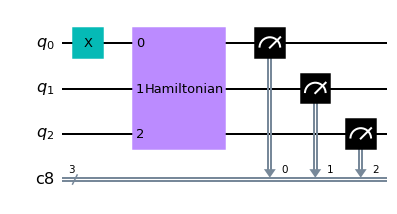

In [44]:
# construct quantum circuit for random eight vertex graph
qr_random = QuantumRegister(3, 'q')
cr_random = ClassicalRegister(3)
circ_random = QuantumCircuit(qr_random, cr_random)

# initialize in state |100> and add measurements
circ_random.x(0)
circ_random.append(ExpGateRandom, qr_random)
for i in range(len(qr_random)):
    circ_random.measure(qr_random[i], cr_random[i])

# visualize resulting circuit
circ_random.draw(output='mpl')

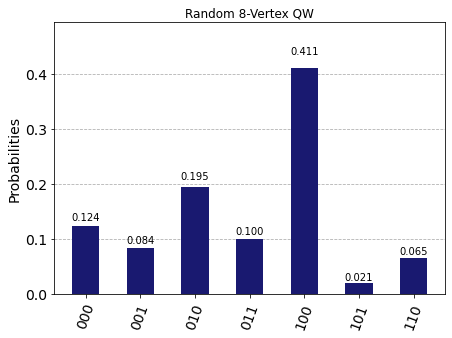

In [48]:
# execute simulation of random graph QW and plot histogram
job = execute(circ_random, backend=BasicAer.get_backend('qasm_simulator'))
plot_histogram(job.result().get_counts(), color='midnightblue', title="Random 8-Vertex QW")

While the above visualizations verify that our code for quantum walks is working correctly, we want to be able to visualize the overall evolution of the quantum walk on the graph instead of just the end result. In order to do this, we developed functions to evolve the state of the quantum system in small pieces, taking a "snapshot" of the state of the system after each iteration. This way, we will be able to better visualize how the "quantum walker" is moving throughout the graph.

In [24]:
def create_walk_circuit(adj_matrix, total_dur, num_snaps):
    '''Function for generating walk circuit with snapshots
    after each evolution of the quantum walk.
    
    Parameters: adj_matrix (ndarray):   adjacency of graph
                total_dur (float):      total time for quantum walk
                num_snaps (int):        number of snapshots throughout walk
    Returns:    circ (QuantumCircuit):  resulting circuit
    '''
    num_qubits = np.log2(len(adj_matrix))
    ExpGate = HamiltonianGate(adj_matrix, total_dur/num_snaps)

    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(num_qubits)
    circ = QuantumCircuit(qr, cr)

    circ.x(0)
    circ.snapshot(str(0))
    for i in range(num_snaps):
        circ.append(ExpGate, qr)
        circ.snapshot(str(i+1))

    return circ

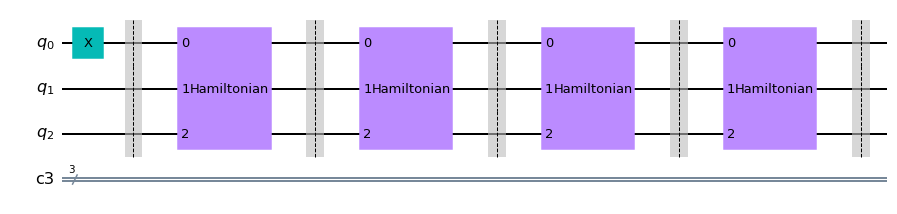

In [25]:
# visualize simple snapshot circuit for random matrix
random_circuit = create_walk_circuit(random_matrix, 2*np.pi, 4)
random_circuit.draw(output='mpl')

In [26]:
def get_snapshots(adj_matrix, total_dur, num_snaps):
    '''Function for returning snapshots of quantum walk.

    Parameters: adj_matrix (ndarray):   adjacency of graph
                total_dur (float):      total time for quantum walk
                num_snaps (int):        number of snapshots throughout walk
    Returns:    map from iteration number to snapshot, snapshot counts 
                up from binary in ordering (00, 01, 10, 11, ...)
    '''
    qc = create_walk_circuit(adj_matrix, total_dur, num_snaps)
    backend = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend).result()
    return result.data()['snapshots']['statevector']

In [97]:
# print example of returned map from get_snapshots
#print("Map:", get_snapshots(full_mat_P3, 2*np.pi, 8))
print("Starting State:", get_snapshots(full_mat_P3, 2*np.pi, 8)['7'])

Starting State: [array([ 0.        +0.j        ,  0.53942727+0.j        ,
        0.        -0.70490494j,  0.        +0.j        ,
       -0.46057273+0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])]
